In [8]:
import numpy as np
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.utils import check_random_state

In [9]:
class KKMeans():
    def __init__(self, n_clusters=8, init="random", n_init=1,
                 max_iter=300, tol=None, verbose=0,
                 random_state=None, algorithm="lloyd", kernel="linear", **kwds):
        self.n_clusters = n_clusters
        self.init = init
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose
        self.random_state = check_random_state(random_state)
        self.algorithm = algorithm
        self.kernel = kernel
        self.kwds = kwds
        self.labels = None
        return
    
    def p_kernel_wrapper(self, x, y=None):
        return pairwise_kernels(x, y, metric=self.kernel, n_jobs=-1, **self.kwds)
    
    def fit(self, data):
        self._check_data(data)
        
        if self.algorithm == "lloyd":
            self._lloyd(data)
        
    def _check_data(self, data):
        return
    
    def _lloyd(self, data):
        kernel_matrix = self.p_kernel_wrapper(data)
        self._init(data, kernel_matrix)
        inertia = 0
        for _ in range(self.max_iter):
            distances = np.tile(np.diag(kernel_matrix), (self.n_clusters, 1)).T
            self._lloyd_iter(kernel_matrix, distances)
            labels_new = np.argmin(distances, axis=1)
            inertia_new = np.amin(distances, axis=1).sum()
            if all(labels_new == self.labels) or abs(inertia - inertia_new) < self.tol:
                if self.verbose:
                    print("Converged at iteration:", _ + 1,
                          "Inertia:", inertia_new)
                break                
            if self.verbose:
                print("Iteration:", _ + 1,
                      "Inertia:", inertia_new)
            self.labels = labels_new
            inertia = inertia_new
    
    def _lloyd_iter(self, kernel_matrix, distances):
        for cluster in range(self.n_clusters):
            mask = (self.labels == cluster)
            n_cluster_elements = sum(mask) 
            if n_cluster_elements == 0:
                if self.verbose:
                    print("Empty Cluster encountered,",  
                          "assigned random element to cluster.")
                self.labels[self.random_state.randint(len(self.labels))] = cluster
                n_cluster_elements = 1      
            # (SUM K(a,b) for a,b in Cluster) / |cluster|**2 
            inner_term = kernel_matrix[mask][:, mask].sum() / (n_cluster_elements ** 2)
            # array that contains for each datapoint x: 2 * (SUM K(x,b) for b in Cluster) / |Cluster|
            element_term = 2 * kernel_matrix[:, mask].sum(axis = 1) / n_cluster_elements
            distances[:, cluster] += inner_term
            distances[:, cluster] -= element_term
    
    def _init(self, data, kernel_matrix):
        if isinstance(self.init, (list, tuple, np.ndarray)):
            self._check_centroids() # TODO 
            self._assign_to_centroids(self.init, data)
            return
        
        elif self.init == "random":
            centroids = data[self.random_state.randint(0, len(data), self.n_clusters)]
            self._assign_to_centroids(centroids, data)
            return
        
        elif self.init == "truerandom":
            self.labels = self.random_state.randint(0, self.n_clusters, len(data))
            return
        
        elif self.init == "kmeans++":
            self._kmeanspp(data, kernel_matrix)
            return 
        
        raise Exception("Unknown initialisation method")
    
    def _check_centroids(self):
        if len(self.init) != self.n_clusters:
            raise Exception("The number of given centroids should match n_clusters") # TODO
        return

    def _assign_to_centroids(self, centroids, data):
        data_centr_kernel = self.p_kernel_wrapper(data, centroids)
        centr_distances = np.zeros((len(data), self.n_clusters))
        for cluster in range(self.n_clusters):
            centr_distances[:, cluster] = (-2 * data_centr_kernel[:, cluster]
                + self.p_kernel_wrapper([centroids[cluster]]))
        self.labels = np.argmin(centr_distances, axis = 1)
        return

    
    def _kmeanspp(self, data, kernel_matrix):
        
        centroids = np.zeros((self.n_clusters, len(data[0])))
        centr_distances = np.tile(np.diag(kernel_matrix), (self.n_clusters, 1)).T   
        for cluster in range(self.n_clusters):
            if cluster == 0:
                #random first center
                index = self.random_state.randint(len(data))
            else:
                max_dist_each = np.amin(centr_distances[:, :cluster + 1], axis = 1)
                max_dist_each[max_dist_each < 0] = 0
                probs = max_dist_each/max_dist_each.sum()
                index = self.random_state.choice(len(data), size = 1, p = probs)
            centroids[cluster] = data[index]
            cluster_term = self.p_kernel_wrapper([centroids[cluster]])
            data_term = self.p_kernel_wrapper(data, [centroids[cluster]])
            centr_distances[:, cluster] += (-2 * data_term + cluster_term).reshape(len(data),)    
        self.labels = np.argmin(centr_distances, axis = 1)
                
        return

In [10]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_circles
from sklearn.cluster import KMeans

In [11]:
def visualize(data, labels):
    if len(data[0]) > 3:
        raise Exception("Dimensionality is too high for visualization")
    elif len(data[0]) == 1:
        plt.scatter(data, [0 for x in range(len(data))], c = labels)
    elif len(data[0]) == 2:
        plt.scatter(data[:,0], data[:,1], c = labels)
    elif len(data[0]) == 3:
        fig = plt.figure()
        ax = fig.add_subplot(projection = "3d")
        ax.scatter(data[:,0], data[:,1], data[:,2], c = labels)

In [41]:
dims = 2
clusters = 10
amount = 2000

In [42]:
x, labels, centers = make_blobs(amount, centers = clusters, return_centers = True, random_state = 0, n_features = dims)
kkm = KKMeans(n_clusters = clusters, verbose = True, init = "kmeans++", kernel = "linear", random_state = 0, tol = 1e-4)

Iteration: 1 Inertia: 5470.07781911977
Iteration: 2 Inertia: 5278.392651205422
Iteration: 3 Inertia: 5139.481942819409
Iteration: 4 Inertia: 4942.335836130298
Iteration: 5 Inertia: 4769.110310593011
Iteration: 6 Inertia: 4661.146268940453
Iteration: 7 Inertia: 4603.277978899288
Iteration: 8 Inertia: 4568.85248442971
Iteration: 9 Inertia: 4548.263166796488
Iteration: 10 Inertia: 4524.6152741604055
Iteration: 11 Inertia: 4484.489405706376
Iteration: 12 Inertia: 4406.279159294284
Iteration: 13 Inertia: 4241.361166750043
Iteration: 14 Inertia: 4002.13127401506
Iteration: 15 Inertia: 3742.1075163247747
Iteration: 16 Inertia: 3606.519508269057
Iteration: 17 Inertia: 3577.303598597562
Iteration: 18 Inertia: 3572.6392190376873
Iteration: 19 Inertia: 3571.548666586068
Iteration: 20 Inertia: 3571.2390498161526
Iteration: 21 Inertia: 3571.033183994893
Converged at iteration: 22 Inertia: 3570.8468899262116


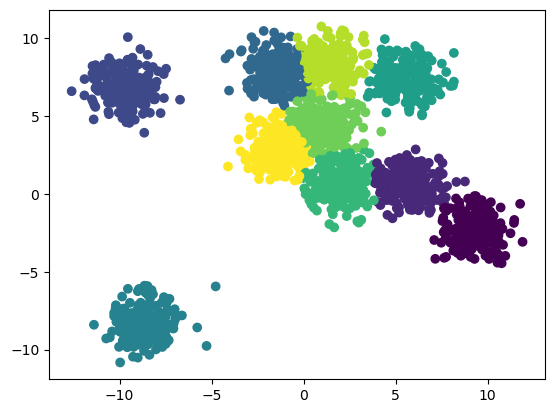

In [43]:
kkm.fit(x)
visualize(x, kkm.labels)

Initialization complete
Iteration 0, inertia 5203.155934184562
Iteration 1, inertia 4377.265678420013
Iteration 2, inertia 4281.294674283478
Iteration 3, inertia 4232.974590974146
Iteration 4, inertia 4215.61485107294
Iteration 5, inertia 4203.452783133675
Iteration 6, inertia 4196.552072990678
Iteration 7, inertia 4194.275004762484
Iteration 8, inertia 4193.192594775785
Converged at iteration 8: center shift 0.0026083872078776064 within tolerance 0.0030083284614083766.
Initialization complete
Iteration 0, inertia 5637.3140418276325
Iteration 1, inertia 4174.263843868536
Iteration 2, inertia 4118.419795678208
Iteration 3, inertia 4110.893612305019
Iteration 4, inertia 4107.312099868489
Iteration 5, inertia 4103.83691221663
Iteration 6, inertia 4102.951708313392
Converged at iteration 6: center shift 0.0015108277993401784 within tolerance 0.0030083284614083766.
Initialization complete
Iteration 0, inertia 5861.075555232017
Iteration 1, inertia 4235.785865228238
Iteration 2, inertia 3954

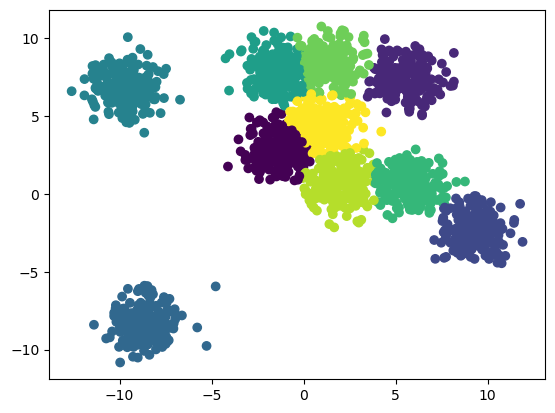

In [44]:
km = KMeans(n_clusters = clusters, init = "k-means++", verbose = True)
km.fit(x)
visualize(x, km.labels_)

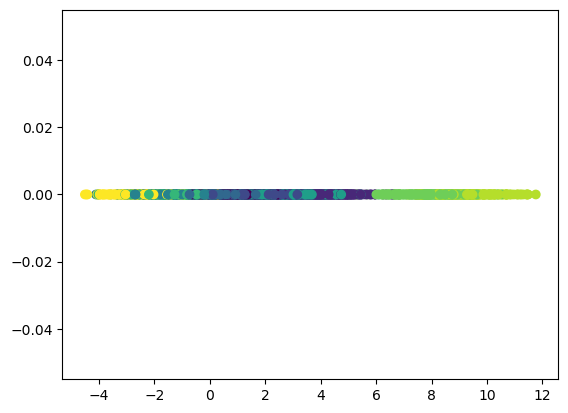

In [40]:
visualize(x, labels)

In [45]:
x, labels = make_circles(1000, factor = 0.3)



In [11]:
kkm = KKMeans(n_clusters = 2, verbose = True, init = "kmeans++", kernel = "rbf", random_state = 0, gamma = 7, tol = None)

Converged at iteration:  12


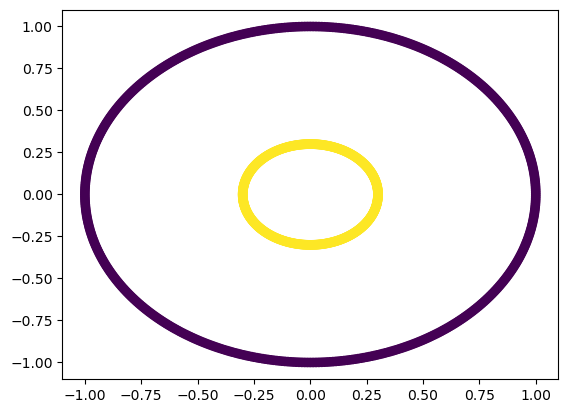

In [13]:
kkm.fit(x)
visualize(x, kkm.labels)